<a href="https://colab.research.google.com/github/kushal-h/Missing-informations-in-News-article/blob/main/Training_model/Missing_news_information_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# pip install -q tf-models-official==2.7.0

##Importing necessary libraries

In [3]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow import keras
import math 
from bs4 import BeautifulSoup
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [4]:
tf.__version__

'2.9.2'

##Loading Dataset

In [5]:
dataset = pd.read_csv('/content/merged_news_classification.csv', engine = 'python', encoding = 'latin1')

Dataset info

Categorizing missing information

0 - Complete

1 - Incomplete

In [6]:
dataset.head()

,headline,label,link,short_description
0,Death Toll In Kentucky Hits 28 As Infrastructu...,1,https://www.huffpost.com/entry/kentucky-flood-...,The number of deaths from massive flooding in ...
1,Vulnerable House Dems See Abortion As Winning ...,0,https://www.huffpost.com/entry/vulnerable-hous...,The Supreme Court decision on abortion has scr...
2,Report: Prince Charles' Charity Got Donation F...,1,https://www.huffpost.com/entry/prince-charles-...,The Prince of Walesâs Charitable Fund accept...
3,âDC League Of Super-Petsâ Takes No. 1 With...,1,https://www.huffpost.com/entry/dc-league-of-su...,The superhero spinoff about Supermanâs dog k...
4,New York City Declares Monkeypox A Public Heal...,1,https://www.huffpost.com/entry/new-york-city-d...,"As many as 150,000 New York City residents cou..."


In [7]:
dataset['headline'][1]

'Vulnerable House Dems See Abortion As Winning Campaign Theme'

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   headline           1002 non-null   object
 1   label              1002 non-null   int64 
 2   link               1002 non-null   object
 3   short_description  996 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [9]:
dataset.isna().sum()

headline             0
label                0
link                 0
short_description    6
dtype: int64

In [10]:
dataset['label'].unique()

array([1, 0])

#Cleaning heading using regular expression

In [11]:
def clean_heading(heading):
  heading = BeautifulSoup(heading, 'lxml').get_text()
  heading = re.sub(r"@[A-Za-z0-9]+", "", heading)
  heading = re.sub(r"https?://[A-Za-z0-9./]", "", heading)
  heading = re.sub(r"[^A-Za-z]", "", heading)
  heading = re.sub(r" +", '', heading)
  return heading

In [12]:
data_clean = [clean_heading(heading) for heading in dataset.headline]

In [13]:
data_clean[0]

'DeathTollInKentuckyHitsAsInfrastructureDamageHampersFloodRecovery'

In [14]:
data_labels = dataset['label'].values

In [15]:
2**10

1024

##Tokenizer

In [16]:
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean,
    target_vocab_size = 2**10
)
     

In [17]:
tokenizer.save_to_file('tokenizer')

In [18]:
encoder = tfds.deprecated.text.SubwordTextEncoder.load_from_file('/content/tokenizer')
     


In [19]:
data_input = [encoder.encode(sentence) for sentence in data_clean]


In [20]:
data_input[0]
     

[1117,
 2656,
 2219,
 427,
 1851,
 803,
 1372,
 72,
 1085,
 57,
 1907,
 819,
 1199,
 1119,
 78,
 3009,
 2059,
 3042,
 1598,
 812]

In [21]:
MAX_LEN = max([len(sentence) for sentence in data_input])


In [22]:
MAX_LEN

49

In [23]:
data_input = tf.keras.preprocessing.sequence.pad_sequences(
    data_input, value = 0, padding = 'post', maxlen = MAX_LEN 
)   

In [24]:
data_input[0]

array([1117, 2656, 2219,  427, 1851,  803, 1372,   72, 1085,   57, 1907,
        819, 1199, 1119,   78, 3009, 2059, 3042, 1598,  812,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

##Splitting into train and test

In [25]:
X = []
y = []

In [26]:
for i in range(0, len(data_input)):
  X.append(data_input[i])
  y.append(data_labels[i])

In [27]:
print(X[0],"\n")
print("heading is:",y[0])     

[1117 2656 2219  427 1851  803 1372   72 1085   57 1907  819 1199 1119
   78 3009 2059 3042 1598  812    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0] 

heading is: 1


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3787,stratify=y )    

In [29]:
print(X_train[0])
y_train[0]

[1125 2846  921  551 1588 2447  717   99  789 3331    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


0

In [30]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

##Building the Model!

In [31]:
class DCNN(tf.keras.Model):

  def __init__(self, vocab_size, dropout_rate = 0.1, training = False, nb_classes = 2,
               FFN_units = 512, nb_filters = 50, emb_dim = 128, name = 'dcnn'):
    
    super(DCNN, self).__init__(name = name)

    self.embedding = tf.keras.layers.Embedding(vocab_size, emb_dim)

    self.bigram = tf.keras.layers.Conv1D(filters = nb_filters, padding = 'valid', kernel_size = 2, activation = 'relu')

    self.pool1 = tf.keras.layers.GlobalMaxPool1D()

    self.trigram = tf.keras.layers.Conv1D(filters = nb_filters, padding = 'valid', kernel_size = 2, activation = 'relu')

    self.pool2 = tf.keras.layers.GlobalMaxPool1D()

    self.fourgram = tf.keras.layers.Conv1D(filters = nb_filters, padding = 'valid', kernel_size = 2, activation = 'relu')

    self.pool3 = tf.keras.layers.GlobalMaxPool1D()

    self.dense = tf.keras.layers.Dense(units = FFN_units, activation = 'relu')

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    if nb_classes == 2:
      self.last_dense = tf.keras.layers.Dense(1, activation = 'sigmoid')

    else:
      self.last_dense = tf.keras.layers.Dense(nb_classes, activation = 'softmax')



  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool1(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool2(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool3(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
    merged = self.dense(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output


##Config

In [32]:
VOCAB_SIZE = encoder.vocab_size

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 32
NB_EPOCHS = 100

In [33]:
model = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [34]:

if NB_CLASSES == 2:
    model.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    model.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])
     

##Creating Checkpoints


In [35]:
checkpoint_path = "ckpt/"

ckpt = tf.train.Checkpoint(model = model)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 1 )

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

     

##Training

In [36]:
history1 = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs= NB_EPOCHS, validation_split = 0.1)
ckpt_manager.save()
     

Epoch 1/100
23/23 [==============================] - 10s 21ms/step - loss: 0.6790 - accuracy: 0.5917 - val_loss: 0.6591 - val_accuracy: 0.6420
Epoch 2/100
23/23 [==============================] - 0s 7ms/step - loss: 0.6131 - accuracy: 0.5944 - val_loss: 0.6555 - val_accuracy: 0.6420
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 0.4107 - accuracy: 0.8931 - val_loss: 0.6883 - val_accuracy: 0.6296
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0911 - accuracy: 0.9958 - val_loss: 0.9281 - val_accuracy: 0.5679
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0124 - accuracy: 0.9986 - val_loss: 1.1851 - val_accuracy: 0.6049
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.2500 - val_accuracy: 0.5679
Epoch 7/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.2922 - val_accuracy: 0.5802
Epoch 8/100

'ckpt/ckpt-1'

In [37]:
loss, acc = model.evaluate(X_test, y_test)


7/7 [==============================] - 0s 10ms/step - loss: 1.6889 - accuracy: 0.6119


In [38]:
acc * 100

61.194032430648804

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


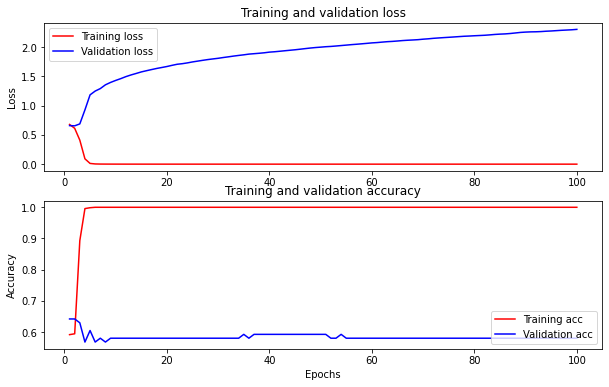

In [39]:
history_dict = history1.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [40]:
sentence = "Elon Musk briefly loses world's richest person title to Louis Vuitton CEO"

In [41]:
sentence = np.array([sentence])

In [42]:
sentence[0]

"Elon Musk briefly loses world's richest person title to Louis Vuitton CEO"

In [43]:
sentence = encoder.encode(sentence[0])

In [44]:
prediction = dict ()
prediction [ 'deeplearning_model1' ] = model.predict ( X_test )

7/7 [==============================] - 0s 2ms/step


In [45]:
pred = model.predict([sentence])

1/1 [==============================] - 0s 112ms/step


In [46]:
pred = pred >= 0.5

In [47]:

if pred:
  print("It has missing information")

else:
  print("It news is alright!")

It news is alright!


In [48]:
model.save('news_classify')

##Second model

In [49]:
def create_model():
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(88587, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid")])
    return model


In [50]:
model2 = create_model()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          5669568   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,883,713
Trainable params: 5,883,713
Non-trainable params: 0
______________________________________________

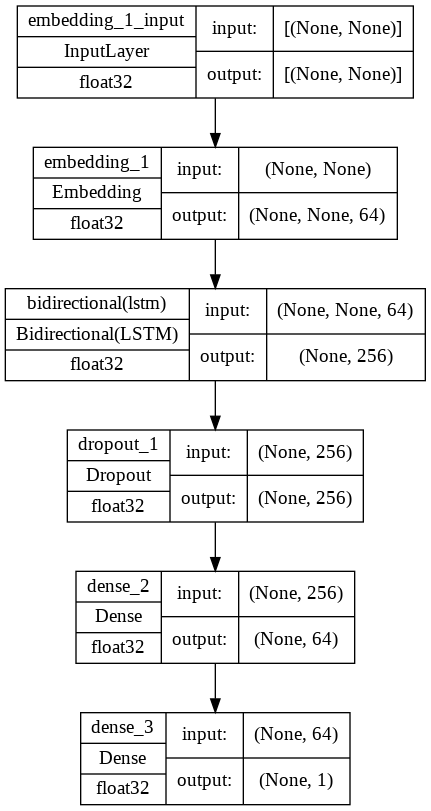

In [51]:


tf.keras.utils.plot_model(model2, to_file = 'plant.png',  show_shapes = True, show_dtype = True, 
                          show_layer_names = True, rankdir='TB', expand_nested = True)

In [52]:
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])

In [53]:
H = model2.fit(X_train,
             y_train,
             epochs=100,
             batch_size=512,
             validation_data=(X_test, y_test),
             verbose=1
             )

Epoch 1/100
2/2 [==============================] - 4s 740ms/step - loss: 0.6916 - acc: 0.5281 - val_loss: 0.6843 - val_acc: 0.6020
Epoch 2/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6824 - acc: 0.5993 - val_loss: 0.6755 - val_acc: 0.6020
Epoch 3/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6741 - acc: 0.5993 - val_loss: 0.6729 - val_acc: 0.6020
Epoch 4/100
2/2 [==============================] - 0s 60ms/step - loss: 0.6691 - acc: 0.5993 - val_loss: 0.6736 - val_acc: 0.6020
Epoch 5/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6649 - acc: 0.5993 - val_loss: 0.6703 - val_acc: 0.6020
Epoch 6/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6536 - acc: 0.5993 - val_loss: 0.6676 - val_acc: 0.6020
Epoch 7/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6394 - acc: 0.6005 - val_loss: 0.6679 - val_acc: 0.6169
Epoch 8/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6176 - acc: 0.7

In [54]:
loss, acc = model2.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 2.5507 - acc: 0.5771


In [55]:
prediction [ 'deeplearning_model2' ] = model2.predict ( X_test )

7/7 [==============================] - 1s 4ms/step


In [56]:
from sklearn.naive_bayes import MultinomialNB

Mmodel = MultinomialNB ().fit ( X_train, y_train.ravel() )
prediction [ 'Multinomial' ] = Mmodel.predict ( X_test )

# %%
from sklearn.naive_bayes import BernoulliNB

Bmodel = BernoulliNB ().fit ( X_train, y_train.ravel(), )
prediction [ 'Bernoulli' ] = Bmodel.predict ( X_test )

# %%
from sklearn import linear_model

logreg = linear_model.LogisticRegression ( C = 1e5, solver = 'lbfgs', max_iter = 300 )
logreg.fit ( X_train, y_train.ravel() )
prediction [ 'Logistic' ] = logreg.predict ( X_test )

# %%
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 100 decision trees
rf = RandomForestRegressor ( n_estimators = 100, random_state = 42 )
# Train the model on training data
rf.fit ( X_train, y_train.ravel() )

r_predicted = rf.predict ( X_test )
r_predicted = np.where ( r_predicted > 0.5, 1, 0 )
prediction [ 'RandomForest' ] = r_predicted

#SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train.ravel())
prediction [ 'SupportVectorMachine' ] = clf.predict ( X_test )

#NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.ravel())
prediction [ 'KNeighborsClassifier' ] = neigh.predict ( X_test )

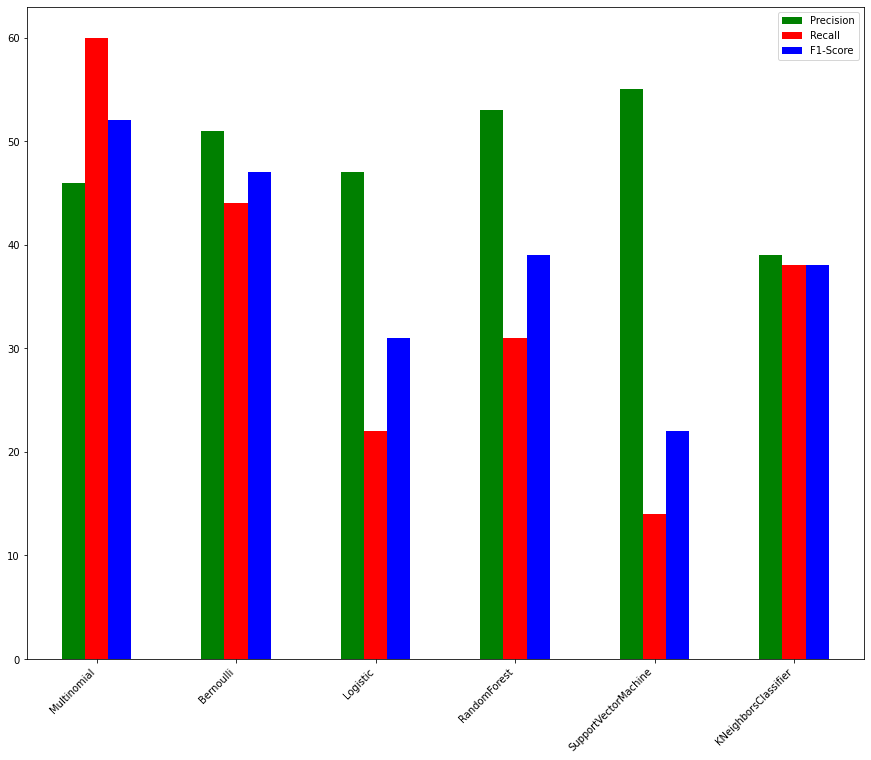

In [57]:
from sklearn import metrics

keys = list(prediction.keys())

another = {
	keys[2] : { 'precision' : round(metrics.precision_score(y_test,prediction[keys[2]]) * 100),
				'recall' : round(metrics.recall_score(y_test,prediction[keys[2]]) * 100),
				'f1-score' : round(metrics.f1_score(y_test,prediction[keys[2]]) * 100)},
	keys[3] : { 'precision' : round(metrics.precision_score(y_test,prediction[keys[3]]) * 100),
				'recall' : round(metrics.recall_score(y_test,prediction[keys[3]]) * 100),
				'f1-score' : round(metrics.f1_score(y_test,prediction[keys[3]]) * 100)},
	keys[4] : { 'precision' : round(metrics.precision_score(y_test,prediction[keys[4]]) * 100),
				'recall' : round(metrics.recall_score(y_test,prediction[keys[4]]) * 100),
				'f1-score' : round(metrics.f1_score(y_test,prediction[keys[4]]) * 100)},
	keys[5] : { 'precision' : round(metrics.precision_score(y_test,prediction[keys[5]]) * 100),
				'recall' : round(metrics.recall_score(y_test,prediction[keys[5]]) * 100),
				'f1-score' : round(metrics.f1_score(y_test,prediction[keys[5]]) * 100)},
  keys[6] : { 'precision' : round(metrics.precision_score(y_test,prediction[keys[6]]) * 100),
				'recall' : round(metrics.recall_score(y_test,prediction[keys[6]]) * 100),
				'f1-score' : round(metrics.f1_score(y_test,prediction[keys[6]]) * 100)},
  keys[7] : { 'precision' : round(metrics.precision_score(y_test,prediction[keys[7]]) * 100),
				'recall' : round(metrics.recall_score(y_test,prediction[keys[7]]) * 100),
				'f1-score' : round(metrics.f1_score(y_test,prediction[keys[7]]) * 100)}
}

precision = [another[keys[2]]['precision'],another[keys[3]]['precision'],another[keys[4]]['precision'],another[keys[5]]['precision'],another[keys[6]]['precision'],another[keys[7]]['precision']]
recall = [another[keys[2]]['recall'],another[keys[3]]['recall'],another[keys[4]]['recall'],another[keys[5]]['recall'],another[keys[6]]['recall'],another[keys[7]]['recall']]
f1_score = [another[keys[2]]['f1-score'],another[keys[3]]['f1-score'],another[keys[4]]['f1-score'],another[keys[5]]['f1-score'],another[keys[6]]['f1-score'],another[keys[7]]['f1-score']]

df = pd.DataFrame({'Precision': precision,
                    'Recall': recall,
				   	'F1-Score' : f1_score}, index=keys[2:])
ax = df.plot.bar(rot=0, color={"Precision": "green", "Recall": "red", "F1-Score": "blue"}, figsize = (15,12))
plt.xticks(rotation = 45,ha='right')
plt.show()

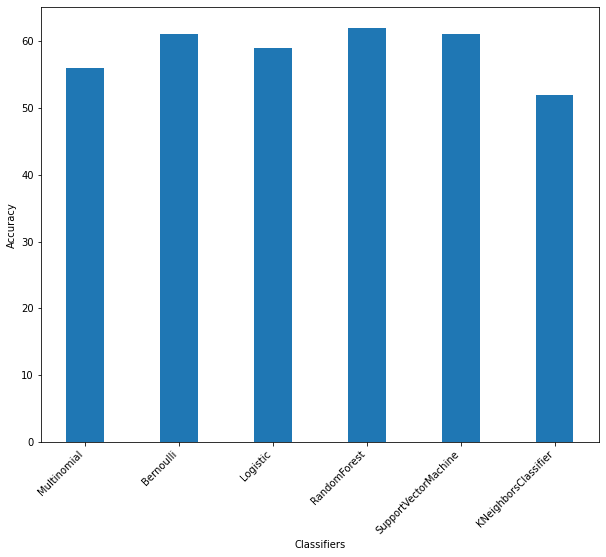

In [58]:
accuracies = {
			  keys[2] : round(metrics.accuracy_score(y_test,prediction[keys[2]]) * 100),
			  keys[3] : round(metrics.accuracy_score(y_test,prediction[keys[3]]) * 100),
			  keys[4] : round(metrics.accuracy_score(y_test,prediction[keys[4]]) * 100),
			  keys[5] : round(metrics.accuracy_score(y_test,prediction[keys[5]]) * 100),
        keys[6] : round(metrics.accuracy_score(y_test,prediction[keys[6]]) * 100),
        keys[7] : round(metrics.accuracy_score(y_test,prediction[keys[7]]) * 100)
			  }

models = list(accuracies.keys())
values = list(accuracies.values())

fig = plt.figure(figsize = (10, 8))
# creating the bar plot
plt.bar(models, values, width = 0.4)
plt.xticks(rotation = 45,ha='right')
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

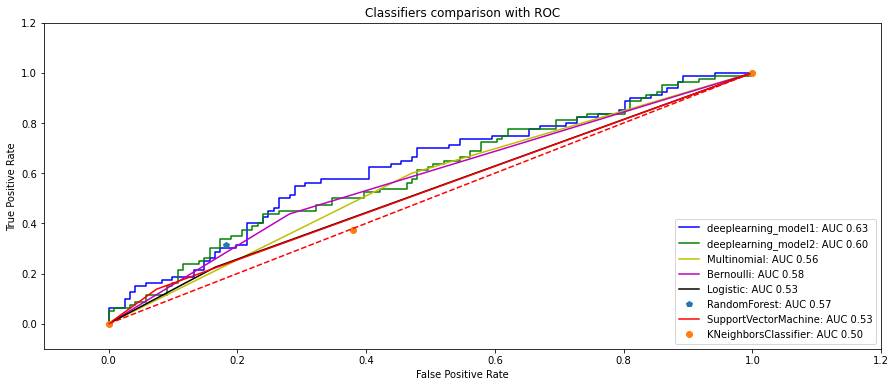

In [59]:
cmp = 0
plt.figure(figsize=(15,6))

colors = [ 'b', 'g', 'y', 'm', 'k', 'p', 'r', 'o' ]
for model, predicted in prediction.items ():
	false_positive_rate, true_positive_rate, thresholds = roc_curve ( y_test, predicted )
	roc_auc = auc ( false_positive_rate, true_positive_rate )
	plt.plot ( false_positive_rate, true_positive_rate, colors [ cmp ], label = '%s: AUC %0.2f' % (model, roc_auc) )
	cmp += 1

plt.title ( 'Classifiers comparison with ROC' )
plt.legend ( loc = 'lower right' )
plt.plot ( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim ( [ -0.1, 1.2 ] )
plt.ylim ( [ -0.1, 1.2 ] )
plt.ylabel ( 'True Positive Rate' )
plt.xlabel ( 'False Positive Rate' )
plt.show ()